In [9]:
import h5py
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict
import xarray as xr

plt.rcParams['figure.figsize'] = [16, 10]

In [36]:
def find_pfx(file, pfx):
    for k in file:
        if k.startswith(pfx):
            return k
        
def read_mfields(file):
    fields = {}
    for k in file:
        if k.startswith('jeh-') or k.startswith('all_1st-') or k.startswith('fields_vpic-') or k.startswith('hydro_vpic-'):
            mrc_fld = file[k]
            for kk in mrc_fld:
                group = file[k + '/' + kk]
                dsets = [group[p]['3d'] for p in group]
                fields[kk] = dsets
    return fields

def read_mcrds(file, bnd=0):
#    mrc_crds = file[find_pfx(file, 'mrc_crds')]

    mcrds = {}
    for d, crd in enumerate(['x', 'y', 'z']):
        mcrds_path = find_pfx(file, 'crd[{}]-'.format(d)) #)'mrc_m1_{}'.format(mrc_crds.attrs['mcrd{}'.format(d)][0])
        group = file[mcrds_path + '/crd[{}]'.format(d)]
        paths = [p + "/1d" for p in group]
        dsets = [group[path] for path in paths]
        if (bnd):
            dsets = [dset[bnd:-bnd] for dset in dsets]
        mcrds[crd] = dsets
        
    return mcrds

def read_pfd(path, step, nodes=1, pfx='pfd', bnd=0):
    files = [h5py.File(path + '/{}.{:06d}_p{:06d}.h5'.format(pfx, step, node)) for node in range(nodes)]

    fields = defaultdict(list)
    crds = defaultdict(list)
    for file in files:
        mfields = read_mfields(file)
        for f in mfields:
            fields[f] += mfields[f]
        mcrds = read_mcrds(file, bnd)
        for f in mcrds:
            crds[f] += mcrds[f]
            
    return fields, crds

def read_field(fieldname, path, step, nodes=1, bnd=0):
    fields, crds = read_pfd(path, step=step, nodes=nodes, bnd=bnd)
    assert fieldname in fields
#     if not fieldname in fields:
#         fields, crds = read_pfd(path, step=step, nodes=nodes, pfx='pfd_moments')
    return xr.DataArray(fields[fieldname][0][:].T, coords=[crds[d][0][:] for d in "xyz"], dims=['x', 'y', 'z'])

In [90]:
path = '/Users/kai/src/psc/build-spack-ubuntu2'
step = 100
def plot_fields(fldnames, fld_kwargs=None):
    fig, axs = plt.subplots(len(fldnames), 1)
    if len(fldnames) == 1: axs = [axs]
    for i, fldname in enumerate(fldnames):
        fld = read_field(fldname, path, step=step, bnd=2)
        if fld_kwargs:
            kwargs = fld_kwargs[i]
        else:
            kwargs = {}
        fld.T.plot(ax=axs[i], **kwargs)
        axs[i].set_aspect('equal')

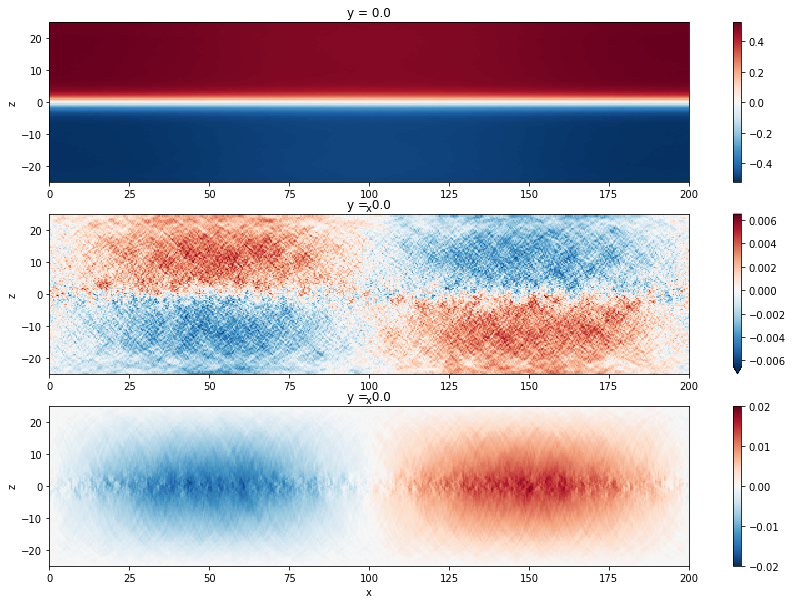

In [91]:
plot_fields(['hx_fc', 'hy_fc', 'hz_fc'],
           fld_kwargs=[{}, {"vmin": -.0065}, {"vmin": -.02}])

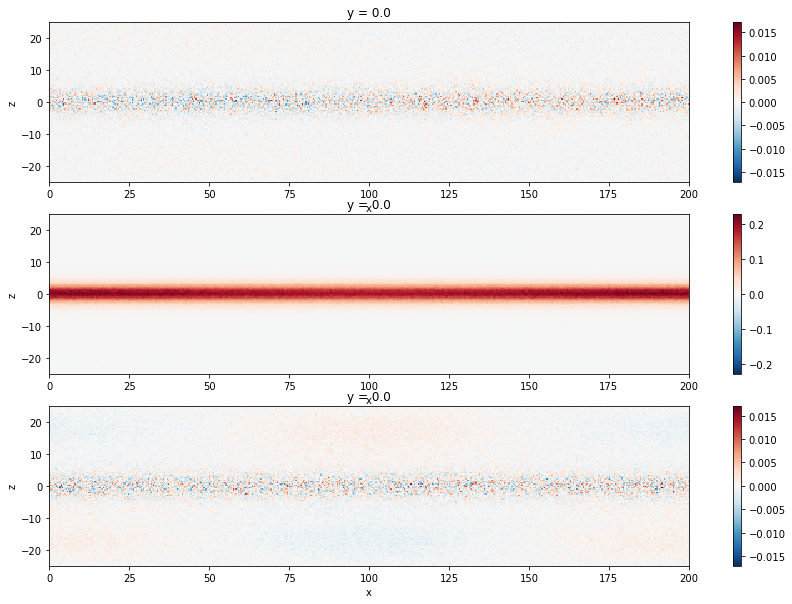

In [92]:
plot_fields(['jx_ec', 'jy_ec', 'jz_ec'])

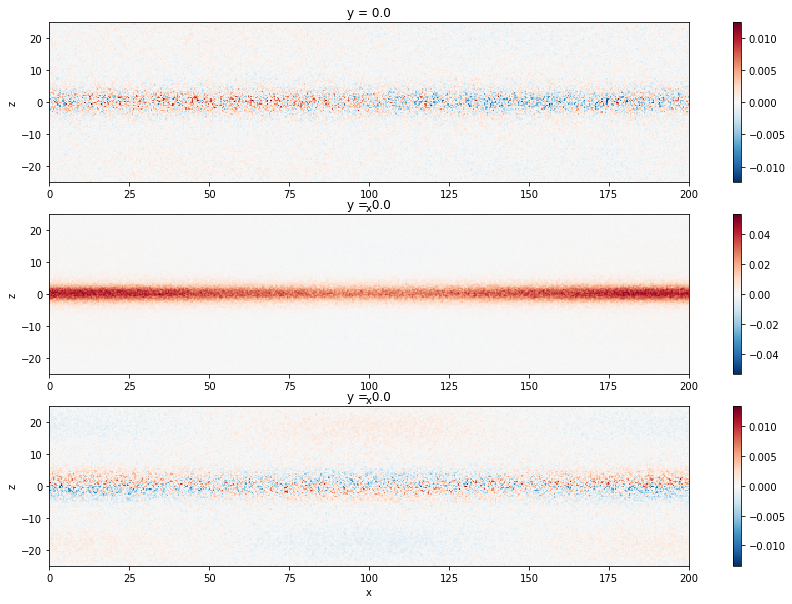

In [93]:
plot_fields(['jx_nc_e', 'jy_nc_e', 'jz_nc_e'])

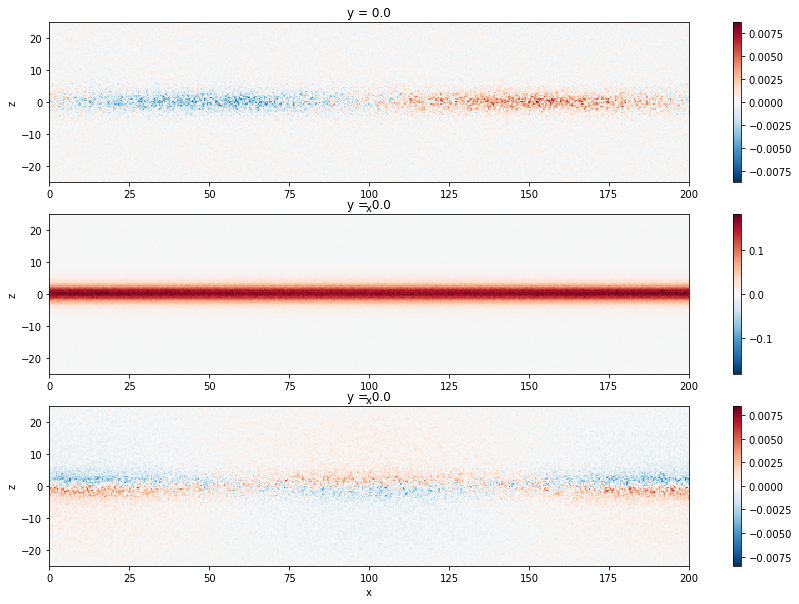

In [94]:
plot_fields(['jx_nc_i', 'jy_nc_i', 'jz_nc_i'])

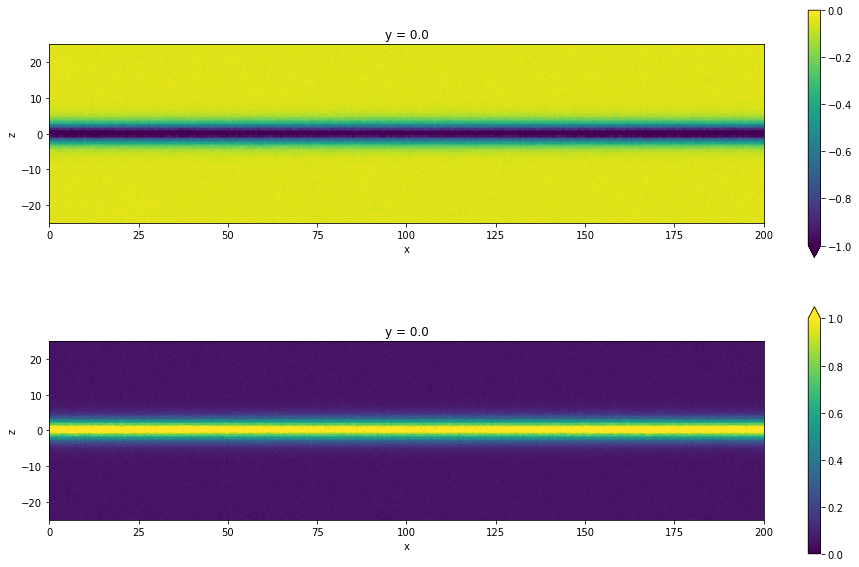

In [95]:
plot_fields(['rho_nc_e', 'rho_nc_i'], 
            fld_kwargs=[{"vmin": -1, "vmax": 0}, 
                        {"vmin": 0, "vmax": 1}])

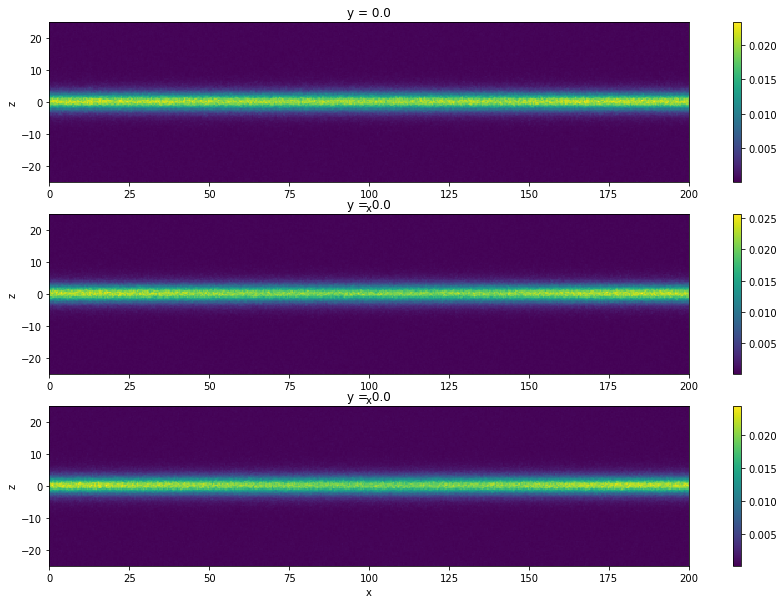

In [96]:
plot_fields(['txx_nc_e', 'tyy_nc_e', 'tzz_nc_e'])

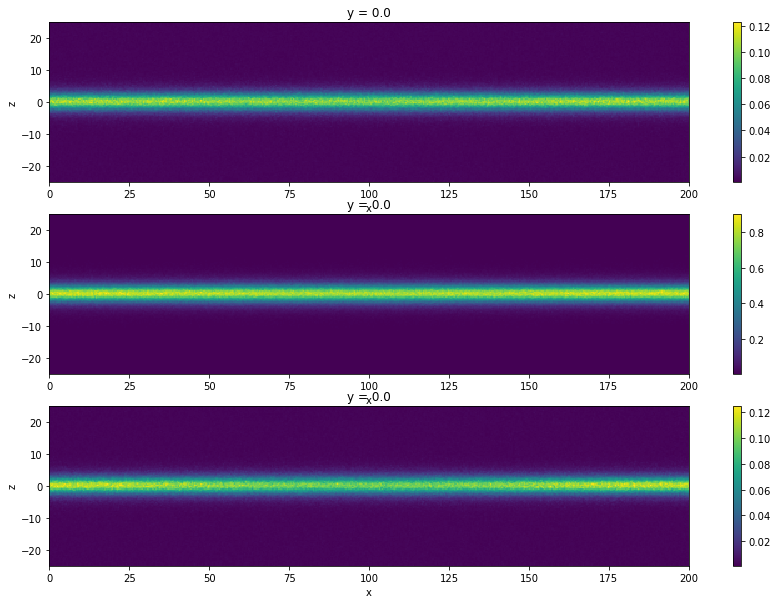

In [97]:
plot_fields(['txx_nc_i', 'tyy_nc_i', 'tzz_nc_i'])